<font color='tomato'><font color="#CC3D3D"><p>
# Neural Collaborative Filtering (NCF): Basic Model

- 행렬분해(MF)의 MLP 변환    

<img src='NCF_Basics.jpeg' align="left" width=800>

- NCF 아키텍처   

<img src='NCF_Basic_architecture.jpeg' align="left" width=800/>

### Import modules

In [27]:
import pandas as pd
import numpy as np
import pickle, random, os
import warnings; warnings.filterwarnings("ignore")
import matplotlib.pylab as plt
%matplotlib inline

from msr.python_splitters import (
    python_random_split, 
    python_chrono_split, 
    python_stratified_split
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.17.0


### Set random seeds to make your results reproducible

In [28]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
#    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET") 
   
reset_seeds()

RANDOM SEEDS RESET


### Step 1: Load and process the data

##### Read data

In [29]:
movies = pd.read_csv('/Users/kimminsu/Desktop/AI,BIGDATA CLASS/Recommender System/data/movies.csv')    # 영화 정보
ratings = pd.read_csv('/Users/kimminsu/Desktop/AI,BIGDATA CLASS/Recommender System/data/ratings.csv')  # 사용자가 영화에 대해 남긴 평점 데이터

movies.shape, ratings.shape

((9724, 3), (100836, 4))

##### Split data into train & test set 

In [30]:
#train, test = python_random_split(ratings, ratio=0.75)
train, test = train_test_split(ratings, test_size=0.25, shuffle=True, random_state=0)

### Step 2: Define the model architecture

##### Stack layers from input to output

In [31]:
# Variable 초기화 
K = 200                             # Latent factor 수 
mu = train.rating.mean()            # 전체 평균 
M = ratings.userId.nunique() + 1    # Number of users
N = ratings.movieId.nunique() + 1   # Number of movies

M, N

(611, 9725)

- 새로운 아이템, 유저를 대비해 +1을 둠
- 1번부터 실행하기 위해
-> 실무에서는 +2를 함 

In [32]:
ratings.userId

0           1
1           1
2           1
3           1
4           1
         ... 
100831    610
100832    610
100833    610
100834    610
100835    610
Name: userId, Length: 100836, dtype: int64

In [33]:
user = keras.Input(shape=(1, ))                          # User input: userID
item = keras.Input(shape=(1, ))                          # Item input: movieId

P_embedding = keras.layers.Embedding(M, K)(user)         # M: Number of users, K: Latent factor 수 
Q_embedding = keras.layers.Embedding(N, K)(item)         # M: Number of movies, K: Latent factor 수 

user_bias = keras.layers.Embedding(M, 1)(user)           # User bias term 
item_bias = keras.layers.Embedding(N, 1)(item)           # Item bias term

R = keras.layers.Dot(axes=2)([P_embedding, Q_embedding]) # 행렬곱: P * Q 
R = keras.layers.Add()([R, user_bias, item_bias])
R = keras.layers.Flatten()(R)

#R = Dense(32, activation='relu')(R)
#R = Dense(16, activation='relu')(R)
#R = Dense(1, activation='linear')(R)

model = keras.Model(inputs=[user, item], outputs=R)

##### Summarize & visualize the model

In [34]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 200)    │    122,200 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 200)    │  1,945,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1, 1)      │          0 │ embedding_4[0][0… │
│                     │                   │            │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 1, 1)      │        611 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 1, 1)      │      9,725 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 1)      │          0 │ dot_1[0][0],      │
│                     │                   │            │ embedding_6[0][0… │
│                     │                   │            │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ add_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,077,536 (7.93 MB)

 Trainable params: 2,077,536 (7.93 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# 연결 그래프 시각화: graphviz와 pydot 설치 필요 (graphviz 다운로드하고 설치한 후 pip install pydot)
keras.utils.plot_model(model, show_shapes=True, rankdir='BT')

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Step 3: Choose the optimizer and the cost function

In [36]:
# loss, optimizer, metrics 설정
model.compile(
    loss='mse',
    optimizer=keras.optimizers.Adam(), 
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')]
)

### Step 4: Train the model

##### Set learning conditions & fit the model 

In [37]:
hist = model.fit(
    x=[train.userId, train.movieId],
    y=train.rating - mu,
    validation_split=0.1,
    batch_size=256, 
    epochs=50, 
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    shuffle=False,
    verbose=2
)

Epoch 1/50
266/266 - 2s - 8ms/step - loss: 1.0274 - rmse: 1.0136 - val_loss: 0.9667 - val_rmse: 0.9832
Epoch 2/50
266/266 - 2s - 6ms/step - loss: 0.8269 - rmse: 0.9093 - val_loss: 0.8274 - val_rmse: 0.9096
Epoch 3/50
266/266 - 1s - 5ms/step - loss: 0.5314 - rmse: 0.7290 - val_loss: 0.7547 - val_rmse: 0.8688
Epoch 4/50
266/266 - 1s - 5ms/step - loss: 0.2975 - rmse: 0.5455 - val_loss: 0.7439 - val_rmse: 0.8625
Epoch 5/50
266/266 - 1s - 5ms/step - loss: 0.1588 - rmse: 0.3985 - val_loss: 0.7513 - val_rmse: 0.8668
Epoch 6/50
266/266 - 1s - 5ms/step - loss: 0.0864 - rmse: 0.2940 - val_loss: 0.7604 - val_rmse: 0.8720
Epoch 7/50
266/266 - 1s - 5ms/step - loss: 0.0485 - rmse: 0.2203 - val_loss: 0.7696 - val_rmse: 0.8773
Epoch 8/50
266/266 - 1s - 5ms/step - loss: 0.0290 - rmse: 0.1703 - val_loss: 0.7755 - val_rmse: 0.8806
Epoch 9/50
266/266 - 1s - 5ms/step - loss: 0.0185 - rmse: 0.1361 - val_loss: 0.7807 - val_rmse: 0.8836


##### Visualize training history 

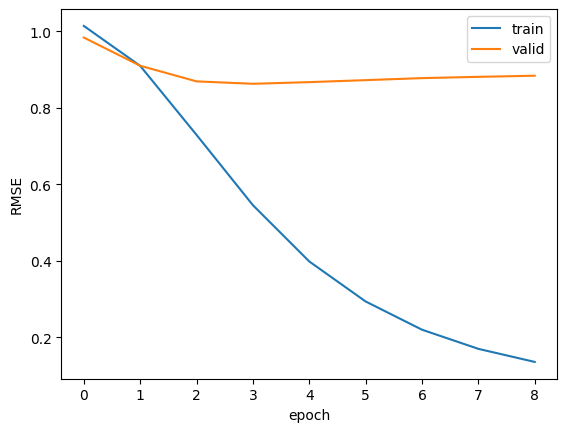

In [38]:
# Plot RMSE

plt.plot(hist.history['rmse'], label="train")
plt.plot(hist.history['val_rmse'], label="valid")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### Step 5: Make predictions

##### Evaluate the model

In [39]:
# 평가데이터에 대한 RMSE 측정

y_pred = model.predict([test.userId, test.movieId]) + mu
y_pred = y_pred.flatten()
y_true = test.rating

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE = {rmse:.3f}')

788/788 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
RMSE = 0.898


##### Make recommendations

In [40]:
# Top-N 영화 추천

N = 10
targetUser = 276

# 본 영화 제외
seen_movies = ratings.query('userId == @targetUser').movieId.unique()
movie_ids = pd.Series(np.array(list(set(ratings.movieId.unique()) - set(seen_movies))))

In [41]:
movie_ids.shape

(9683,)

In [42]:
# 평점 예측 대상 영화수만큼 userId 반복
user_ids = pd.Series(np.array([targetUser]*len(movie_ids)))
user_ids.shape

(9683,)

In [43]:
# 평점 예측
predictions = model.predict([user_ids, movie_ids]) + mu

# 가장 평점이 높은 N개의 영화를 추천
pd.DataFrame({'movieId':movie_ids, 'pred': predictions.flatten()}).sort_values(by='pred', ascending=False).head(N)

303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step


,movieId,pred
758,793,5.192422
2312,2353,5.064191
1244,1285,5.053172
2153,2194,4.952065
900,938,4.934809
775,811,4.934381
1996,2037,4.924119
1444,1485,4.917516
486,506,4.909354
1875,1916,4.893578


###  Step 6: Save the model

In [44]:
# pickle 형식으로 저장
# with open('ncf_model.pkl', 'wb') as f:
#    pickle.dump(model, f)

# 추후 저장한 모형 불러올 때: 
# model = pd.read_pickle('ncf_model.pkl')

<font color="#CC3D3D"><p>
# End